# Logistic Regression Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay, classification_report, make_scorer, fbeta_score, RocCurveDisplay, DetCurveDisplay, precision_recall_curve
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE


## Load Data

In [2]:
data_full = pd.read_csv("../data/processed/full_all_day_ahead.csv")
cols_1da = [c for c in data_full.columns if c.endswith("_1") or c == "Abnormal"]
data_1da = data_full[cols_1da]
data_1da = data_1da.dropna()
data_1da_reduced = data_1da.drop(columns="RR_1")
col_drop_subset = ["DPB_1", "DPH_1", "HTH_1", "TAGI_1", "RRIR_1", "TLRR_1", "OGO_1"]
X = data_1da_reduced.drop(columns="Abnormal")
y = data_1da_reduced.Abnormal

## Data Splitting and Resampling

In [3]:
np.random.seed(500)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y)
class_bal = pd.concat([pd.Series(y_test).value_counts(), pd.Series(y_train).value_counts()], axis=1)

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

class_bal = pd.concat([class_bal, pd.Series(y_train).value_counts()], axis=1)
class_bal.columns = ["Test", "Train (Pre-SMOTE)", "Train (Post-SMOTE)"]
class_bal


,Test,Train (Pre-SMOTE),Train (Post-SMOTE)
Abnormal,,,
0.0,756,1764,1764
1.0,11,24,1764


## Full Model

In [4]:
# for idx_train, idx_test in StratifiedKFold(n_splits=10).split(X_train, y_train):
#   mod_full = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(penalty=None, max_iter=10000))
#   ])
#   mod_full.fit(X_train.iloc[idx_train], y_train[idx_train])
#   pred_probs = mod_full.predict_proba(X_train.iloc[idx_test])[:,1]

#   thres = [i/100 for i in range(101)]
#   opt_thres = -1
#   max_f2 = -1
#   for t in thres:
#     pred_y = [0 if p < t else 1 for p in pred_probs]
#     prec, rec, f2, _ = precision_recall_fscore_support(y_train[idx_test], pred_y, beta=2, average="binary", zero_division=0)
#     if f2 > max_f2: 
#       max_f2 = f2
#       opt_thres = t
    
  
#   print(f"Optimal threshold: {opt_thres} F2: {max_f2}")

In [5]:
mod_full = Pipeline([
  ("scaler", StandardScaler()),
  ("clf", LogisticRegression(penalty=None, max_iter=10000))
])
mod_full.fit(X_train, y_train)
# pred_probs = mod_full.predict_proba(X_test)[:,1]
# pred_y = [0 if p < 0.24 else 1 for p in pred_probs]
# ConfusionMatrixDisplay.from_predictions(y_test, pred_y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=10000, penalty=None))])

In [6]:
# print(f"Precision: {9/(9+267)}")
# print(classification_report(y_test, pred_y, labels=[1]))

## Full - Ridge

In [7]:
pipe_l2 = Pipeline([
  ("scaler", StandardScaler()),
  ("clf", LogisticRegression(max_iter=10000, penalty="l2", solver="saga", n_jobs=-1))
])

param_grid = {
  "clf__C": [1*10**p for p in range(-4, 4)],
  "clf__fit_intercept": [False, True],
}

kf = StratifiedKFold(n_splits=10)
search = GridSearchCV(pipe_l2, param_grid, scoring = make_scorer(fbeta_score, beta=2), n_jobs=-1, refit=True)
search.fit(X_train, y_train)
print("Best params:", search.best_params_)
mod_l2 = search.best_estimator_

Best params: {'clf__C': 0.01, 'clf__fit_intercept': False}


In [8]:
# betas = mod_l2.named_steps["clf"].coef_
# pd.Series(betas[0], index=X_train.columns)

## Reduced

In [9]:
X_tr_sub = X_train.drop(columns=col_drop_subset)
X_te_sub = X_test.drop(columns=col_drop_subset)

mod_red = Pipeline([
  ("scaler", StandardScaler()),
  ("clf", LogisticRegression(penalty=None, max_iter=10000))
])
mod_red.fit(X_tr_sub, y_train)
# pred_probs = mod_full.predict_proba(X_te_sub)[:,1]
# pred_y = [0 if p < 0.24 else 1 for p in pred_probs]
# ConfusionMatrixDisplay.from_predictions(y_test, pred_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=10000, penalty=None))])

## Reduced + Ridge

In [10]:
pipe_l2_red = Pipeline([
  ("scaler", StandardScaler()),
  ("clf", LogisticRegression(max_iter=10000, penalty="l2", solver="saga", n_jobs=-1))
])

param_grid = {
  "clf__C": [1*10**p for p in range(-4, 4)],
  "clf__fit_intercept": [False, True],
}

kf = StratifiedKFold(n_splits=10)
search = GridSearchCV(pipe_l2, param_grid, scoring = make_scorer(fbeta_score, beta=2), n_jobs=-1, refit=True)
search.fit(X_tr_sub, y_train)
print("Best params:", search.best_params_)
mod_l2_red = search.best_estimator_

Best params: {'clf__C': 0.1, 'clf__fit_intercept': False}


## PCA

In [11]:
# Full
pca = PCA()
pca.fit(StandardScaler().fit_transform(X_train))
pca.explained_variance_ratio_.cumsum()

array([0.38099155, 0.62887331, 0.73472794, 0.79738702, 0.85852992,
       0.90503563, 0.94113508, 0.97144731, 0.9913685 , 0.99868863,
       0.99943526, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [12]:
# Reduced
pca = PCA()
pca.fit(StandardScaler().fit_transform(X_tr_sub))
pca.explained_variance_ratio_.cumsum()

array([0.31624228, 0.51837221, 0.6454801 , 0.74456321, 0.83839752,
       0.90269315, 0.95040879, 0.98327758, 1.        , 1.        ])

In [13]:
pipe_pca = Pipeline([
  ("scaler", StandardScaler()),
  ("pca", PCA()),
  ("clf", LogisticRegression(penalty=None, max_iter=10000))
])

param_grid = {"pca__n_components": [x for x in range(1, X_train.shape[1])]}
kf = StratifiedKFold(n_splits=10)

search = GridSearchCV(pipe_pca, param_grid, scoring = make_scorer(fbeta_score, beta=2), n_jobs=-1, refit=True)
search.fit(X_train, y_train)
print("Best params:", search.best_params_)
mod_pca = search.best_estimator_

Best params: {'pca__n_components': 10}


In [14]:
pipe_pca_red = Pipeline([
  ("scaler", StandardScaler()),
  ("pca", PCA()),
  ("clf", LogisticRegression(penalty=None, max_iter=10000))
])

param_grid = {"pca__n_components": [x for x in range(1, X_te_sub.shape[1])]}
kf = StratifiedKFold(n_splits=10)

search = GridSearchCV(pipe_pca_red, param_grid, scoring = make_scorer(fbeta_score, beta=2), n_jobs=-1, refit=True)
search.fit(X_tr_sub, y_train)
print("Best params:", search.best_params_)
mod_pca_red = search.best_estimator_

Best params: {'pca__n_components': 9}


## Threshold Selection and Comparison

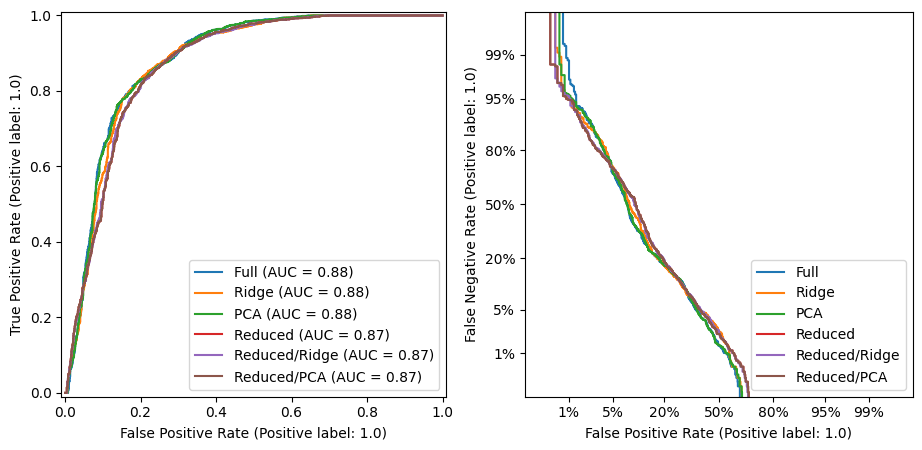

In [15]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

models = {
  "Full": mod_full,
  "Ridge": mod_l2,
  "PCA": mod_pca,
  "Reduced": mod_red,
  "Reduced/Ridge": mod_l2_red,
  "Reduced/PCA": mod_pca_red
}
for name, mod in models.items():
  # xtest = X_te_sub if "Reduced" in name else X_test
  xtrain = X_tr_sub if "Reduced" in name else X_train
  RocCurveDisplay.from_estimator(mod, xtrain, y_train, ax=ax_roc, name=name, drop_intermediate=False)
  DetCurveDisplay.from_estimator(mod, xtrain, y_train, ax=ax_det, name=name)

In [16]:
for name, mod in models.items():
  xtrain = X_tr_sub if "Reduced" in name else X_train
  y_prob = mod.predict_proba(xtrain)[:,1]
  
  t_iter = []
  f2_iter = []

  for idx_train, idx_test in StratifiedKFold(n_splits=10).split(X_train, y_train):
    mod_full = Pipeline([
      ("scaler", StandardScaler()),
      ("clf", LogisticRegression(penalty=None, max_iter=10000))
    ])
    mod_full.fit(X_train.iloc[idx_train], y_train[idx_train])
    pred_probs = mod_full.predict_proba(X_train.iloc[idx_test])[:,1]

    thres = [i/100 for i in range(len(np.unique(pred_probs)))]
    opt_thres = -1
    max_f2 = -1
    for t in thres:
      pred_y = [0 if p < t else 1 for p in pred_probs]
      prec, rec, f2, _ = precision_recall_fscore_support(y_train[idx_test], pred_y, beta=2, average="binary", zero_division=0)
      if f2 > max_f2: 
        max_f2 = f2
        opt_thres = t
      
    t_iter += [opt_thres]
    f2_iter += [max_f2]
  
  print(f"{name} - Opt thresh: {t_iter[np.argmax(f2_iter)]}")

Full - Opt thresh: 0.28
Ridge - Opt thresh: 0.28
PCA - Opt thresh: 0.28
Reduced - Opt thresh: 0.28
Reduced/Ridge - Opt thresh: 0.28
Reduced/PCA - Opt thresh: 0.28


Full - precision: 0.03361, recall: 0.7273, f2: 0.06426
Ridge - precision: 0.02821, recall: 0.8182, f2: 0.05455
PCA - precision: 0.02941, recall: 0.6364, f2: 0.05622
Reduced - precision: 0.03019, recall: 0.7273, f2: 0.05797
Reduced/Ridge - precision: 0.02797, recall: 0.7273, f2: 0.05387
Reduced/PCA - precision: 0.03019, recall: 0.7273, f2: 0.05797


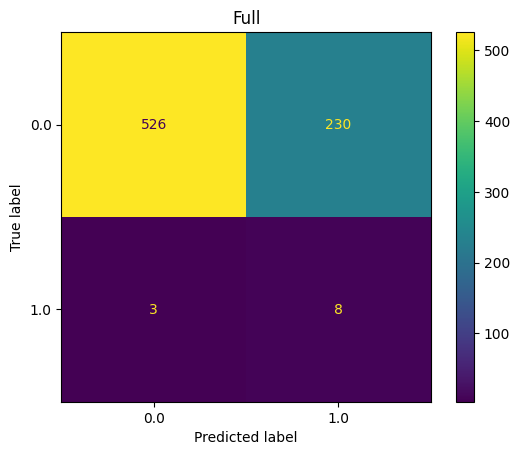

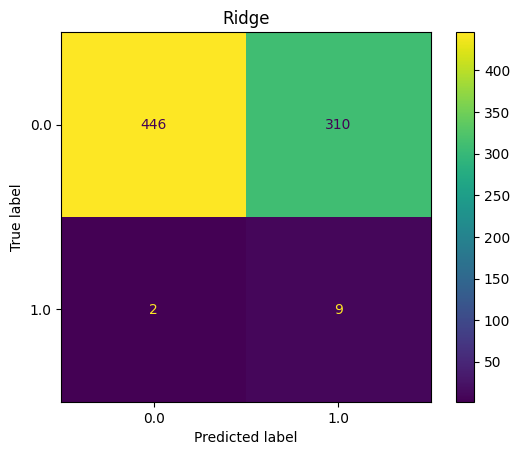

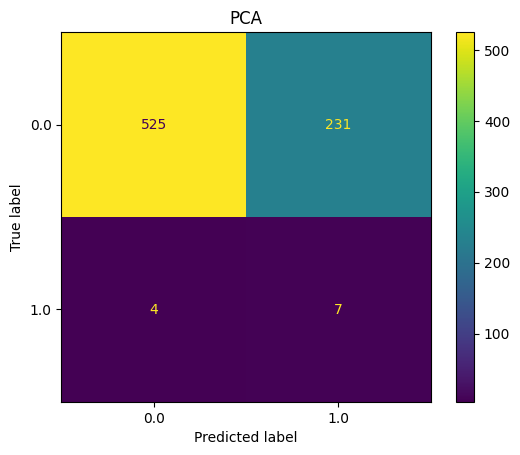

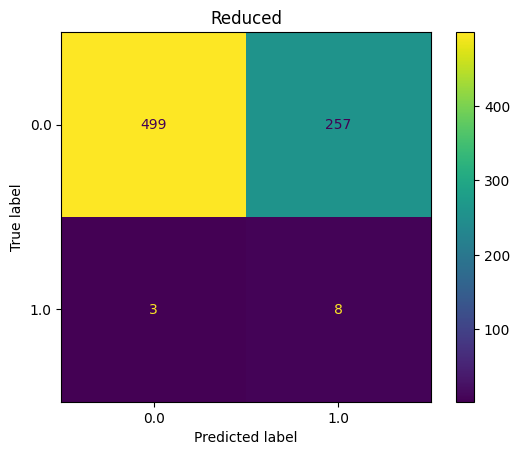

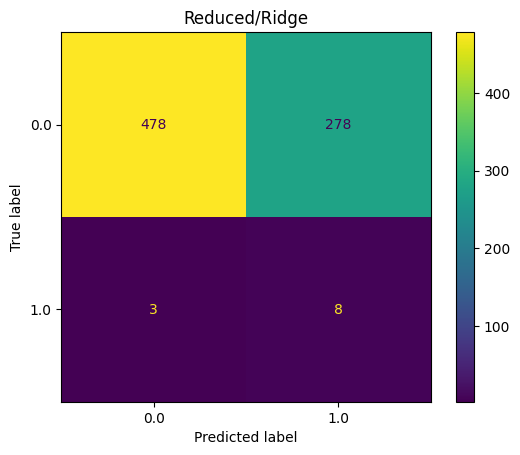

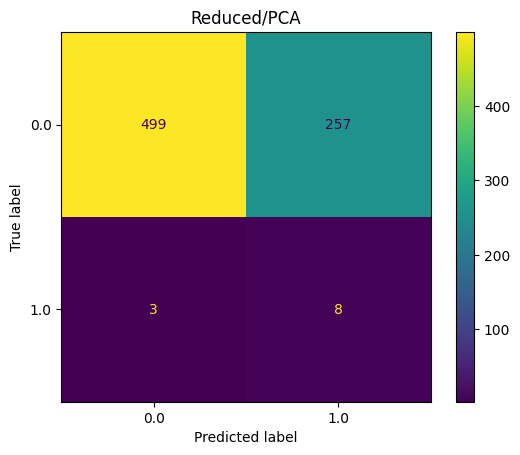

In [17]:
for name, mod in models.items():
  xtest = X_te_sub if "Reduced" in name else X_test
  test_prob = mod.predict_proba(xtest)[:,1]
  test_pred = [0 if p < 0.28 else 1 for p in test_prob]

  p, r, f2, supp = precision_recall_fscore_support(y_test, test_pred, average="binary", zero_division=0)
  print(f"{name} - precision: {p:.4}, recall: {r:.4}, f2: {f2:.4}")

  disp = ConfusionMatrixDisplay.from_predictions(y_test, test_pred)
  disp.ax_.set_title(name)